In [1]:
import wandb

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import random

import gymnasium as gym

import os
import sys
sys.path.append('../src/')
from scipy.spatial.distance import cdist

import torch
import torch.nn as nn
from torch.nn import functional as F


In [2]:
def get_distance_matrix(X,Y):
  """"""
  return cdist(X,Y,metric='euclidean')

def get_distance(point1,point2):
    """Compute Euclidean distance between two points."""
    return np.linalg.norm(point1 - point2)


# Import files from src

In [3]:
sys.path.append('../src')
from environments import ToyEnv_v2
from offline_dataset import ToyOfflineDatasetv2
from test_utils import seed_everything
from algorithms import DDQN
from agents import Agent

In [4]:
SEED = 10
seed_everything(SEED)
env_name = 'ToyEnv_v2'

OUTDIR = f'results/{env_name}/'
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

torch.set_default_dtype(torch.float32)

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

train_size = 1

# Simulate train data

In [5]:
def get_closest_dist_ordering(coords, distance_matrix):
    """
    Given a list of coordinates, picks the field closest to the origin first, then 
    always picks the field closest unless it has already been visited
    """
    # matrix where each row corresponds to ordered indices of which is furthest
    ordered_mat_indices = np.argsort(distance_matrix, axis=1) # low to high

    # get index closest to origin
    last_ind = 0
    target_indices = [last_ind]
    row_index = last_ind
    for _ in range(len(coords) - 1):
        col_index = 0 # index of col of matrix

       # if this index has already been chosen, 
        current_ind = ordered_mat_indices[row_index][col_index]
        while current_ind in target_indices:
            col_index += 1
            current_ind = ordered_mat_indices[row_index][col_index]
        target_indices.append(current_ind)
        row_index = current_ind
    return target_indices

def reward_function(target_coords):
    coords = target_coords[:, :-1, :]
    last_coords = target_coords[:, 1:, :]
    
    separation = np.linalg.norm(coords - last_coords, axis=2)
    mean_sep, std_sep = np.mean(separation), np.std(separation)
    
    low_sep_lim = mean_sep - .5 * std_sep
    mid_sep_lim = mean_sep + .5 * std_sep
    max_sep_lim = mean_sep + 1.5 * std_sep
    max_reward_mask = separation < low_sep_lim
    mid_reward_mask = np.logical_and(separation < mid_sep_lim, separation >= low_sep_lim)
    low_reward_mask = np.logical_and(separation <= max_sep_lim, separation >= mid_sep_lim)
    reward_shape = (len(target_coords), len(target_coords[0]) - 1)

    rewards = np.zeros(shape=reward_shape, dtype=np.float32)
    rewards[low_reward_mask] = .1
    rewards[mid_reward_mask] = .5
    rewards[max_reward_mask] = 1
    
    return rewards, separation

def get_nvisits(target_field_ids, nfields):
    # start with 0 visits
    train_size = len(target_field_ids)
    nvisits_base = np.zeros(shape=(nfields), dtype=np.int32)
    full_nvisits = np.zeros(shape=(train_size, len(target_field_ids[0]) - 1, nfields), dtype=np.int32)

    # for each night and each field in night, add 1 count to field then copy new nvisits base into full_nvisits[night,obs]
    for i, night_obs in enumerate(target_field_ids):
        for j, field_id in enumerate(night_obs[1:]):
            nvisits_base[field_id] += 1
            full_nvisits[i, j] = nvisits_base.copy()
        # print(np.argwhere(nvisits_base))
    return full_nvisits

In [6]:
def generate_dataset(n_datasets=100, n_unique=10, n_obs_per_night=10):
    """
    Generates the following dataset
        (1) a random sample of points on a 20x20 integer grid for x number of nights with a static number of observations per night.
        (2) Each night the first observation is always the one that is closest to zenith, and always chooses the next point to be the one that is closest.
        (3) The set of quantities needed to perform training
    
    Returns
    -------
    
    """
    grid_max = 5
    ra_range = (-grid_max, grid_max)
    dec_range = (-grid_max, grid_max)
    # set number of unique fields
    max_visits = int(n_datasets * n_obs_per_night / n_unique)

    # generate random coords
    ra_list = np.random.randint(ra_range[0], ra_range[1], size=(n_unique), dtype=np.int32)
    dec_list = np.random.randint(dec_range[0], dec_range[1], size=(n_unique), dtype=np.int32)
    unique_coords = np.stack([ra_list, dec_list], axis=1) # shape (num_ep, nra_points, ndec_points)
    unique_field_ids = np.arange(len(unique_coords), dtype=np.int32)
    field_coord_mapping = {id: c for id, c in zip(unique_field_ids, unique_coords)}
    field_coord_mapping.update({-1: np.array([0,0])})

    # repeat coords for full dataset
    coords = np.repeat(unique_coords, max_visits, axis=0)
    field_ids = np.repeat(unique_field_ids, max_visits)
    
    # randomize order
    new_indices = list(range(len(coords)))
    random.shuffle(new_indices)
    coords = coords[new_indices]
    field_ids = field_ids[new_indices]
    coords = coords.reshape((n_datasets, n_obs_per_night, 2))
    field_ids = field_ids.reshape((n_datasets, n_obs_per_night))
     
    # include "-1" fields ie (0,0)
    zeros = np.zeros(shape=(n_datasets, 2), dtype=np.int32)
    coords = np.concatenate((zeros[:, np.newaxis, :], coords), axis=1)
    field_ids = np.concatenate( (np.full(n_datasets, fill_value=-1)[:, np.newaxis], field_ids), axis=1)

    distance_matrices = np.empty(shape=(n_datasets, n_obs_per_night+1, n_obs_per_night+1), dtype=np.float32)
    full_target_fields = []
    full_target_coords = []

    for i in range(n_datasets):
        distance_matrices[i] = get_distance_matrix(coords[i], coords[i])
        np.fill_diagonal(distance_matrices[i], np.inf)
        target_indices = get_closest_dist_ordering(coords[i], distance_matrices[i])
        full_target_fields.append(field_ids[i][target_indices])
        full_target_coords.append(coords[i][target_indices])

    full_target_fields = np.array(full_target_fields, dtype=np.int32)
    full_target_coords = np.array(full_target_coords, dtype=np.int32)
    nfields =  np.int32(len(np.unique(full_target_fields)) - 1)
    #max_visits =  #np.int32(len(full_target_fields) // nfields * (len(full_target_fields[0]) - 1))
    full_nvisits = get_nvisits(full_target_fields, nfields)
    # full_stepnum = np.array([np.arange(0, 10, dtype=np.int32) for i in range(len(full_target_fields))], dtype=np.int32)
    
    # obs: stepnum, target_coords, target_field_ids, nvisits
    # full_obs = (full_target_fields[:, :-1]) #full_target_coords[:, :-1], full_stepnum[:, :-1], , full_nvisits[:, :-1])
    # full_next_obs = (full_target_fields[:, 1:]) #full_target_coords[:, 1:], full_stepnum[:, 1:], , full_nvisits[:, 1:])
    full_actions = full_target_fields[:, 1:]
    full_rewards, full_separations = reward_function(full_target_coords)
    full_dones = np.zeros_like(full_target_fields[:, 1:], dtype=bool)
    full_dones[:, -1] = True
    full_action_masks = full_nvisits != max_visits
    # full_action_mask = action_masks[:, :-1]
    # full_next_action_mask = action_masks[:, 1:]
    obs = np.concatenate((full_target_fields[:, :-1, np.newaxis], full_target_coords[:, :-1]), axis=2)
    next_obs = np.concatenate((full_target_fields[:, 1:, np.newaxis], full_target_coords[:, 1:]), axis=2)

    return obs, full_actions, full_rewards, next_obs, full_dones, full_action_masks, nfields, max_visits, full_separations, field_coord_mapping

In [7]:
seed_everything(SEED)
obs, full_actions, full_rewards, next_obs, full_dones, full_action_masks, nfields, max_visits, full_separations, field_coord_mapping \
    = generate_dataset(train_size)

## Visualize data

(array([1., 4., 1., 1., 0., 0., 1., 0., 1., 1.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

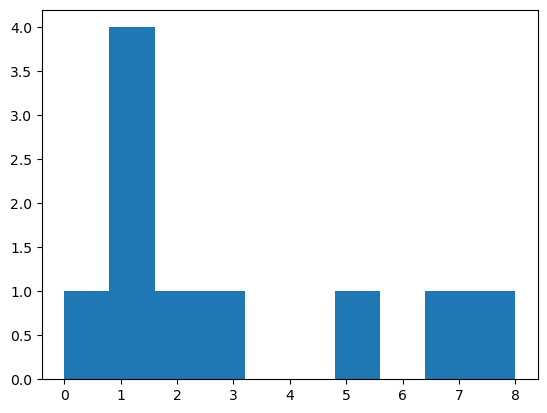

In [8]:
plt.hist(full_separations.flatten())

Text(0.5, 1.0, 'Separations')

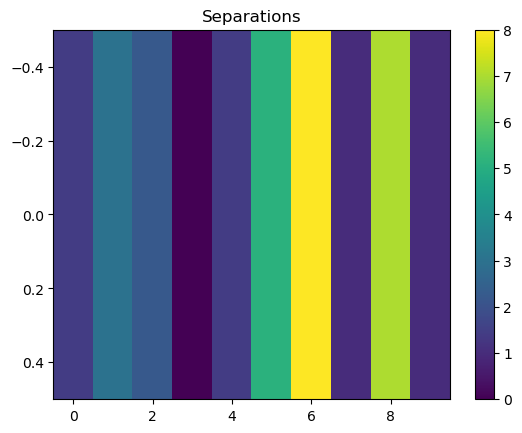

In [9]:
c = plt.imshow(full_separations, aspect='auto')
plt.colorbar(c)
plt.title('Separations')

(array([2., 1., 0., 0., 0., 2., 0., 0., 0., 5.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

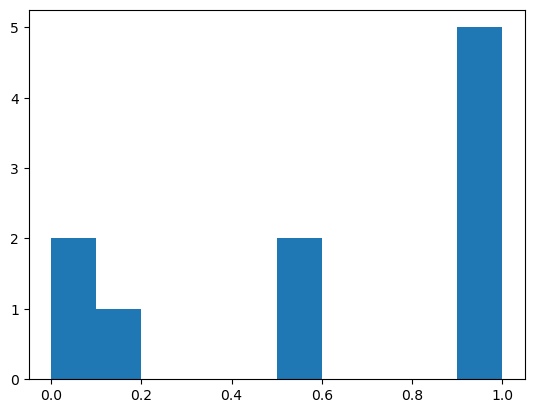

In [10]:
plt.hist(full_rewards.flatten())

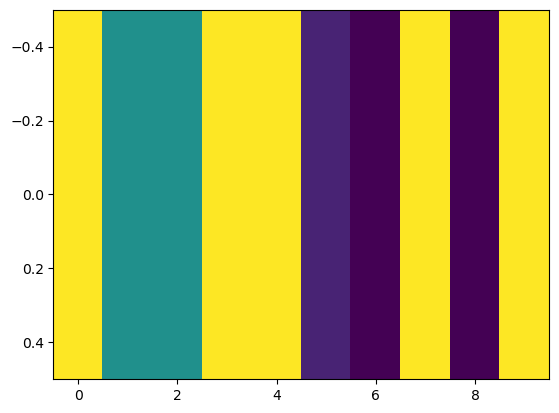

In [11]:

c = plt.imshow(full_rewards, aspect='auto')

In [12]:
full_target_coords = obs[:, :, 1:]
full_target_fields = obs[:, :, 0]

9


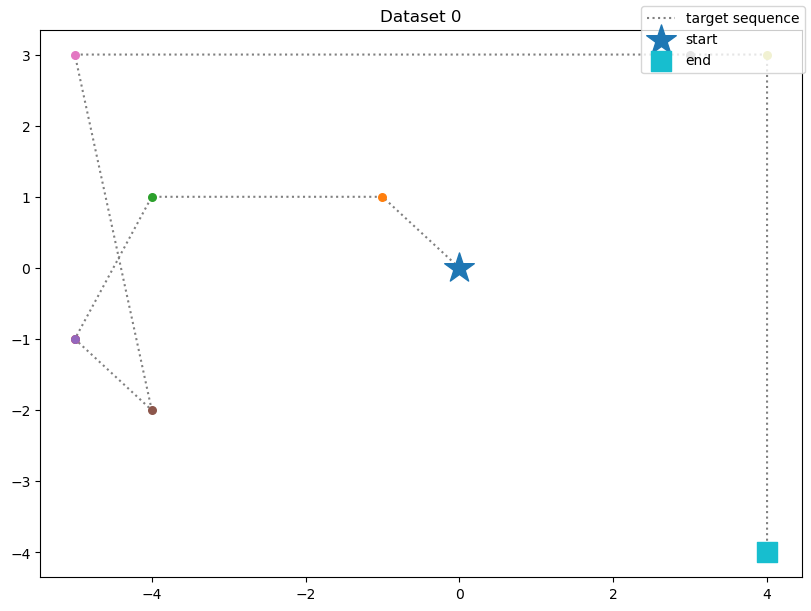

In [13]:
j = np.random.randint(train_size)

fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
ax.plot(full_target_coords[j][:, 0], full_target_coords[j][:, 1], linestyle='dotted', label='target sequence', zorder=1, color='grey')

for i, index in enumerate(full_target_fields[j]):
    if i == 0:
        marker = '*'
        s = 500
        label='start'
    elif i == len(full_target_fields[j])-1:
        print(i)
        marker = 's'
        s = 200
        label='end'
    else:
        marker = 'o'
        s = 30
        label=None
    ax.scatter(full_target_coords[j][i][0], full_target_coords[j][i][1], marker=marker, s=s, label=label)
# fig.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
fig.legend()
ax.set_title(f'Dataset {j}');

# Pytorch Agent and DQN implementation

## Offline dataset class

In [14]:
from collections.abc import Callable

class ToyOfflineData:
    def __init__(self, data_generator: Callable, train_size: int):
        self.data_generator = data_generator
        self.train_size = train_size
        self.obs, self.actions, self.rewards, self.next_obs, self.dones, self.action_masks, self._nfields, self._max_visits, self._full_separations, self._field_coord_mapping\
            = data_generator(train_size)
        
        self._obs_per_night = len(self.obs[0])
        self._obs_dim = 3 #(1 (coords) + 1 (field_id) )
        self._action_dim = self._nfields #doesn't include zenith
        self.rewards = (self.rewards - np.mean(self.rewards)) / (np.std(self.rewards) + 1e-8)

    def __len__(self):
        return self.train_size

    def sample(self, batch_size):
        #TODO possible to have repeat night/step combos bc replace = True
        night_indices = np.random.choice(self.train_size, batch_size, replace=True)
        step_num_indices = np.random.choice(self._obs_per_night - 1, batch_size)

        # field_ids = self.obs[0][night_indices, step_num_indices]
        # coords = self.obs[1][night_indices, step_num_indices]
        # obs = np.concatenate((field_ids[:, np.newaxis], coords), axis=1)

        # next_field_ids = self.obs[0][night_indices, step_num_indices+1]
        # next_coords = self.obs[1][night_indices, step_num_indices+1]
        # next_obs = np.concatenate((next_field_ids[:, np.newaxis], next_coords), axis=1)
        
        return (
            np.array(self.obs[night_indices, step_num_indices], dtype=np.float32), # needs to be float for network
            np.array(self.actions[night_indices, step_num_indices], dtype=np.int32),
            np.array(self.rewards[night_indices, step_num_indices], dtype=np.float32),
            np.array(self.next_obs[night_indices, step_num_indices], dtype=np.float32),
            np.array(self.dones[night_indices, step_num_indices], dtype=np.bool_),
            np.array(self.action_masks[night_indices, step_num_indices], dtype=bool),
        )

## Instantiate offline dataset

Need the dataset to intitiate environment

In [15]:
seed_everything(SEED)
dataset = ToyOfflineDatasetv2(generate_dataset, 1)

In [16]:
# Register the environment so we can create it with gym.make()
gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=ToyEnv_v2,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)
env = gym.make(f"gymnasium_env/{env_name}", dataset=dataset)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)


In [17]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


In [18]:
alg_config = {
    'obs_dim': dataset._obs_dim,
    'action_dim': dataset._action_dim,
    'hidden_dim': 128,
    'gamma': .99,
    'tau': .001,
    'device': device,
    'lr': 1e-5,
    'loss_fxn': F.huber_loss,
    'use_dqn': False
}

alg = DDQN(**alg_config)

In [19]:
agent_config = {
    'algorithm': alg,
    'name': 'ddqnAgent'
    }

In [20]:
agent = Agent(**agent_config)

In [21]:
agent.fit(
    dataset,
    num_epochs=5000,
    batch_size=8, 
    outdir=OUTDIR
    )

	 epoch: 0
	 epoch: 1
	 epoch: 2
	 epoch: 3
	 epoch: 4
	 epoch: 5
	 epoch: 6
	 epoch: 7
	 epoch: 8
	 epoch: 9
	 epoch: 10
	 epoch: 11
	 epoch: 12
	 epoch: 13
	 epoch: 14
	 epoch: 15
	 epoch: 16
	 epoch: 17
	 epoch: 18
	 epoch: 19
	 epoch: 20
	 epoch: 21
	 epoch: 22
	 epoch: 23
	 epoch: 24
	 epoch: 25
	 epoch: 26
	 epoch: 27
	 epoch: 28
	 epoch: 29
	 epoch: 30
	 epoch: 31
	 epoch: 32
	 epoch: 33
	 epoch: 34
	 epoch: 35
	 epoch: 36
	 epoch: 37
	 epoch: 38
	 epoch: 39
	 epoch: 40
	 epoch: 41
	 epoch: 42
	 epoch: 43
	 epoch: 44
	 epoch: 45
	 epoch: 46
	 epoch: 47
	 epoch: 48
	 epoch: 49
	 epoch: 50
	 epoch: 51
	 epoch: 52
	 epoch: 53
	 epoch: 54
	 epoch: 55
	 epoch: 56
	 epoch: 57
	 epoch: 58
	 epoch: 59
	 epoch: 60
	 epoch: 61
	 epoch: 62
	 epoch: 63
	 epoch: 64
	 epoch: 65
	 epoch: 66
	 epoch: 67
	 epoch: 68
	 epoch: 69
	 epoch: 70
	 epoch: 71
	 epoch: 72
	 epoch: 73
	 epoch: 74
	 epoch: 75
	 epoch: 76
	 epoch: 77
	 epoch: 78
	 epoch: 79
	 epoch: 80
	 epoch: 81
	 epoch: 82
	 epoch: 83
	 

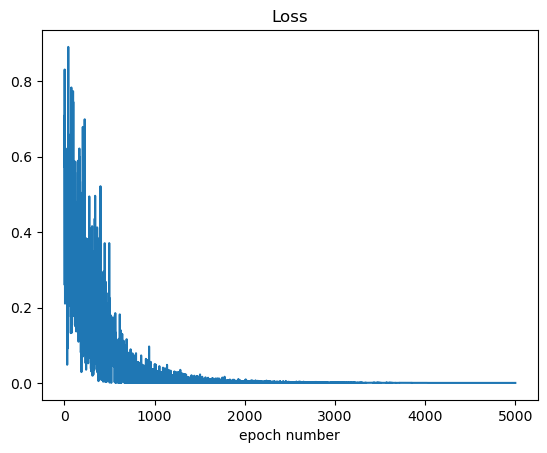

Text(0, 0.5, 'Q vlaue')

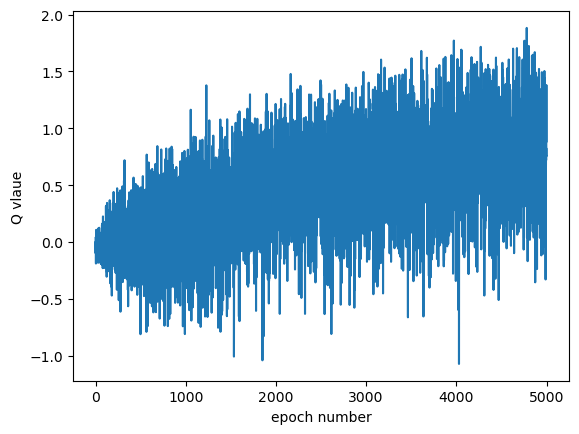

In [ ]:
plt.plot(agent.loss_history)
plt.title('Loss')
plt.xlabel('epoch number')
plt.show();
plt.plot(agent.q_history)
plt.xlabel('epoch number')
plt.ylabel('Q vlaue')

## Env

In [39]:
class ToyEnv_v2(gym.Env):
    def __init__(self, dataset):
        super().__init__()
        # instantiate static attributes
        self.nfields = dataset._nfields
        self.coords_dict = dataset._field_coord_mapping
        self.max_visits = 1
        self.zenith = dataset._field_coord_mapping[-1]
        self._n_obs_per_night = dataset._obs_per_night

        # Initialize variable attributes - will be set in reset()
        self._init_to_nonstate()
       
        # Define observation space - (step (size 1), coords (size 2), nvisits array)
        self.obs_dim = dataset._obs_dim

        self.observation_space = gym.spaces.Box(
            low=np.min(dataset.obs),
            high=np.max(dataset.obs),
            shape=(self.obs_dim,),
            dtype=np.float32,
        )

        # Define action space        
        self.action_space = gym.spaces.Discrete(self.nfields)
    
    # ------------------------------------------------------------ #
    # -----------------------Gymnasium API ----------------------- #
    # ------------------------------------------------------------ #

    def reset(self, seed=None, options=None):
        """Start a new episode.

        Args:
            seed: Random seed for reproducible episodes
            options: Additional configuration (unused in this example)

        Returns:
            tuple: (observation, info) for the initial state
        """
        # IMPORTANT: Must call this first to seed the random number generator
        super().reset(seed=seed)

        # initialize into a non-state.
        # this allows first field choice to be learned
        self._init_to_nonstate()
        obs = self._get_obs()
        info = self._get_info()
        return obs, info
    
    # TODO
    def _get_reward(self, last_obs, current_obs):
        raise NotImplementedError
    
    def step(self, action: int):
        """Execute one timestep within the environment.

        Args:

        Returns:
        """
        assert self.action_space.contains(action), f"Invalid action {action}"
        last_coord = self._coord
        last_field_id = self._field_id
        self._update_obs(action)
        if self._step_count == 0:
            last_coord = self.zenith
        
        # ------------------- Calculate reward ------------------- #
        # Two reward components
            # 1: separation (50%)
            # 2: field_id (50%)

        # 1. Separation
        separation = np.linalg.norm(self._coord - last_coord)
        low_sep_lim = 3
        mid_sep_lim = 6
        max_sep_lim = 10

        reward = 0
        if separation < low_sep_lim:
            reward += .5
        elif separation < mid_sep_lim:
            reward += .2
        elif separation < max_sep_lim:
            reward += .1
        
        # 2. Field ID
        field_id_diff = np.abs(last_field_id - self._field_id)
        if field_id_diff == 0:
            reward += .5
        elif field_id_diff <= 1:
            reward += .2
        elif field_id_diff <= 3:
            reward += .1
        # ------------------------------------------ #

        # end condition
        truncated = False
        terminated = self._step_count + 1 >= self._n_obs_per_night

        # get obs and info
        next_obs = self._get_obs()
        info = self._get_info()

        return next_obs, reward, terminated, truncated, info

    # ------------------------------------------------------------ #
    # -------------Convenience functions-------------------------- #
    # ------------------------------------------------------------ #

    def _init_to_nonstate(self):
        self._step_count = -1
        self._field_id = -1
        self._coord = self.zenith
        self._action_mask = np.ones(self.nfields, dtype=bool)
        self._visited = []

    def _update_action_mask(self, action):
        """Update mask for cutting invalid actions.
        Must update self._field and self._nvisits before updating actions
        """
        if self._visited.count(action) == self.max_visits:
            self._action_mask[action] = False

    def _update_obs(self, action):
        self._step_count += 1
        self._field_id = action
        self._coord = np.array(self.coords_dict[action], dtype=np.float32)
        self._visited.append(action)
        self._update_action_mask(action)

    def _get_obs(self):
        """Convert internal state to observation format.
    
        Returns:
            dict: Observation with agent and target positions
        """
        obs = np.concatenate((np.array([self._field_id]), self._coord.flatten()), dtype=np.float32)
        return obs

    def _get_info(self):
        """Compute auxiliary information for debugging.

        Returns:
            
        """
        return {'action_mask': self._action_mask.copy()}

In [40]:
# Register the environment so we can create it with gym.make()
gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=ToyEnv_v2,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)
env = gym.make(f"gymnasium_env/{env_name}", dataset=dataset)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)


In [41]:
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


## Q-learning Algorithm

# Instantiate objects and train

In [44]:
seed_everything(SEED)
dataset = ToyOfflineData(generate_dataset, 1)

In [47]:
alg_config = {
    'obs_dim': dataset._obs_dim,
    'action_dim': dataset._action_dim,
    'hidden_dim': 128,
    'gamma': .99,
    'tau': .001,
    'device': device,
    'lr': 1e-5,
    'loss_fxn': F.huber_loss,
    'use_dqn': False
}

alg = DDQN(**alg_config)

In [48]:
agent_config = {
    'algorithm': alg,
    'name': 'ddqnAgent'
    }

In [49]:
agent = Agent(**agent_config)

In [50]:
agent.fit(
    dataset,
    num_epochs=5000,
    batch_size=8, 
    target_freq=4,
    outdir=OUTDIR
    )

	 epoch: 0
	 epoch: 1
	 epoch: 2
	 epoch: 3
	 epoch: 4
	 epoch: 5
	 epoch: 6
	 epoch: 7
	 epoch: 8
	 epoch: 9
	 epoch: 10
	 epoch: 11
	 epoch: 12
	 epoch: 13
	 epoch: 14
	 epoch: 15
	 epoch: 16
	 epoch: 17
	 epoch: 18
	 epoch: 19
	 epoch: 20
	 epoch: 21
	 epoch: 22
	 epoch: 23
	 epoch: 24
	 epoch: 25
	 epoch: 26
	 epoch: 27
	 epoch: 28
	 epoch: 29
	 epoch: 30
	 epoch: 31
	 epoch: 32
	 epoch: 33
	 epoch: 34
	 epoch: 35
	 epoch: 36
	 epoch: 37
	 epoch: 38
	 epoch: 39
	 epoch: 40
	 epoch: 41
	 epoch: 42
	 epoch: 43
	 epoch: 44
	 epoch: 45
	 epoch: 46
	 epoch: 47
	 epoch: 48
	 epoch: 49
	 epoch: 50
	 epoch: 51
	 epoch: 52
	 epoch: 53
	 epoch: 54
	 epoch: 55
	 epoch: 56
	 epoch: 57
	 epoch: 58
	 epoch: 59
	 epoch: 60
	 epoch: 61
	 epoch: 62
	 epoch: 63
	 epoch: 64
	 epoch: 65
	 epoch: 66
	 epoch: 67
	 epoch: 68
	 epoch: 69
	 epoch: 70
	 epoch: 71
	 epoch: 72
	 epoch: 73
	 epoch: 74
	 epoch: 75
	 epoch: 76
	 epoch: 77
	 epoch: 78
	 epoch: 79
	 epoch: 80
	 epoch: 81
	 epoch: 82
	 epoch: 83
	 

# Evaluate

In [52]:
eval_metrics = agent.evaluate(env=env, num_episodes=10)

terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9
terminated at step 9


In [53]:
vars(dataset).keys()

dict_keys(['data_generator', 'train_size', 'obs', 'actions', 'rewards', 'next_obs', 'dones', 'action_masks', '_nfields', '_max_visits', '_full_separations', '_field_coord_mapping', '_obs_per_night', '_obs_dim', '_action_dim'])

In [54]:
eval_metrics.keys()

dict_keys(['mean_reward', 'std_reward', 'min_reward', 'max_reward', 'episode_rewards', 'observations', 'rewards'])

In [55]:
eval_sequence = eval_metrics['observations']['ep-0']
print(eval_sequence.shape)

(11, 3)


In [58]:
eval_sequence, full_sequence_true

(array([[-1.,  0.,  0.],
        [ 1., -1.,  1.],
        [ 6., -4.,  1.],
        [ 2., -5., -1.],
        [ 3., -4., -2.],
        [ 5., -5., -1.],
        [ 4.,  4., -5.],
        [ 0.,  4.,  3.],
        [ 9., -5.,  3.],
        [ 7.,  3.,  3.],
        [ 8.,  4., -4.]], dtype=float32),
 array([[[-1,  0,  0],
         [ 1, -1,  1],
         [ 6, -4,  1],
         [ 5, -5, -1],
         [ 2, -5, -1],
         [ 3, -4, -2],
         [ 9, -5,  3],
         [ 7,  3,  3],
         [ 0,  4,  3],
         [ 8,  4, -4],
         [ 4,  4, -5]]], dtype=int32))

#  Results

10


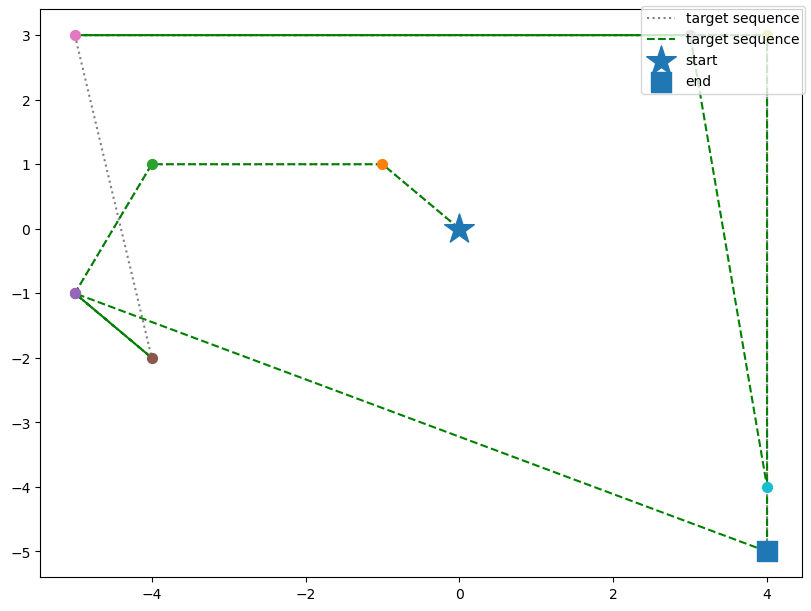

In [64]:
# j = np.random.randint(train_size)

j = 0

full_sequence_true = np.concatenate((dataset.obs, dataset.next_obs[:, -1][np.newaxis, :, :]), axis=1)
eval_sequence = eval_metrics['observations']['ep-0']

fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
ax.plot(full_sequence_true[j][:, 1], full_sequence_true[j][:, 2], linestyle='dotted', label='target sequence', zorder=1, color='grey')
ax.plot(eval_sequence[:, 1], eval_sequence[:, 2], linestyle='dashed', label='target sequence', zorder=1, color='green')

for i, index in enumerate(full_sequence_true[j][:, 0]):
    if i == 0:
        marker = '*'
        s = 500
        label='start'
        color='black'
    elif i == len(full_sequence_true[j][:, 0])-1:
        print(i)
        marker = 's'
        s = 200
        label='end'
    else:
        marker = 'o'
        s = 50
        label=None
    ax.scatter(full_sequence_true[j][i][1], full_sequence_true[j][i][2], marker=marker, s=s, label=label)
# fig.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
fig.legend()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15,8), sharex='row')
fig_hist, ax_hist = plt.subplots()
for i, model_name in enumerate(results.keys()):
    axs[0,i].set_title(model_name, fontsize=20)
    axs[0,i].plot(np.array(true_sequence), marker='o', label='target', color='grey', linestyle='dashed', lw=3)
    axs[0,i].plot(np.array(proposed_survey[i]), marker='o', label='pred')
    axs[0,i].legend()
    axs[0,i].set_ylabel('Object number', fontsize=16)

    residuals = np.array(true_sequence) - np.array(proposed_survey[i])
    axs[1,i].plot(residuals, marker='o')
    axs[1,i].legend()
    axs[1, i].set_xlabel('sequence index', fontsize=16)
    axs[1,i].set_ylabel('residuals', fontsize=16)
    
    ax_hist.hist(residuals, label=model_name, alpha=.5)
    ax_hist.set_xlabel('Residual value')
    ax_hist.set_ylabel('Counts')
    ax_hist.legend(fontsize=16)
fig.tight_layout()

# Tune hyperparameters